In [1]:
# Install the timm package

#!pip -q install timm

In [2]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
#for i in tq.tqdm(...):


import gc

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools


import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


2.5.1+cu121
0.20.1+cu121


In [3]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [4]:
base_path = base_path = '../input/forams-classification-2025/'

In [5]:
os.listdir('../input/forams-classification-2025')

['unlabelled.csv',
 'sample_submission.csv',
 'visualizations',
 'volumes',
 'foram_metric.py',
 'labelled.csv']

## Config

In [6]:
CLASS_LIST_STR = [ '0','1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13']
CLASS_LIST = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]

NUM_CLASSES = len(CLASS_LIST)

NUM_FOLDS = 5

START_FOLD = 0
STOP_FOLD = 5

NUM_EPOCHS = 30

PATIENCE = 5
IMAGE_SIZE = 384 #300 Swin requires size 384
NUM_CHANNELS = 1

L_RATE = 0.0001
BATCH_SIZE = 8


NUM_CORES = os.cpu_count()
NUM_CORES

4

## Define the device

In [7]:
# For GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

cuda:0
Num GPUs: 1
GPU Type: Tesla P100-PCIE-16GB


## Load the train data

In [8]:
path = base_path + '/labelled.csv'

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(210, 2)


id  label
0  labelled_00000      0
1  labelled_00001      0
2  labelled_00002      0
3  labelled_00003      0
4  labelled_00004      0

In [9]:
# Check the target distribution
df_data['label'].value_counts()

label
0     15
1     15
2     15
3     15
4     15
5     15
6     15
7     15
8     15
9     15
10    15
11    15
12    15
13    15
Name: count, dtype: int64

## Add the test images to a dataframe

In [10]:
path = base_path + '/visualizations/visualizations/unlabelled'

image_list = os.listdir(path)

data = {
    "image_fname": image_list
}

df_test = pd.DataFrame(data)

df_test['label'] = 0

print(df_test.shape)

df_test.head()

(18216, 2)


image_fname  label
0  foram_01254.jpg      0
1  foram_16347.jpg      0
2  foram_00700.jpg      0
3  foram_11030.jpg      0
4  foram_16839.jpg      0

In [11]:
# Add an id column

def get_id(x):
    item_id = x.split('_')[1]
    item_id = int(item_id.split('.')[0])

    return item_id

df_test['id'] = df_test['image_fname'].apply(get_id)

# Sort by 'id' in ascending order
df_test = df_test.sort_values(by='id', ascending=True)

# Reset the index
df_test = df_test.reset_index(drop=True)

# Reorder columns
new_order = ['id', 'image_fname', 'label']
df_test = df_test[new_order]

print(df_test.shape)

df_test.head()

(18216, 3)


id      image_fname  label
0   0  foram_00000.jpg      0
1   1  foram_00001.jpg      0
2   2  foram_00002.jpg      0
3   3  foram_00003.jpg      0
4   4  foram_00004.jpg      0

## Process the data

In [12]:
# Add the image fname

# labelled_foram_00035.jpg

def add_image_fname(x):
    
    id_str = x.split('_')[1]
    fname = f"labelled_foram_{id_str}.jpg"

    return fname

df_data['image_fname'] = df_data['id'].apply(add_image_fname)

#df_data.head()

In [13]:
df_data.head()

id  label               image_fname
0  labelled_00000      0  labelled_foram_00000.jpg
1  labelled_00001      0  labelled_foram_00001.jpg
2  labelled_00002      0  labelled_foram_00002.jpg
3  labelled_00003      0  labelled_foram_00003.jpg
4  labelled_00004      0  labelled_foram_00004.jpg

In [14]:
df_test.head()

id      image_fname  label
0   0  foram_00000.jpg      0
1   1  foram_00001.jpg      0
2   2  foram_00002.jpg      0
3   3  foram_00003.jpg      0
4   4  foram_00004.jpg      0

In [15]:
df_test.head()

id      image_fname  label
0   0  foram_00000.jpg      0
1   1  foram_00001.jpg      0
2   2  foram_00002.jpg      0
3   3  foram_00003.jpg      0
4   4  foram_00004.jpg      0

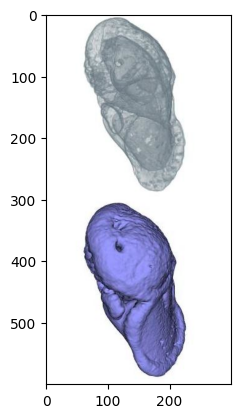

In [16]:
i = 100

fname = df_test.loc[i, 'image_fname']

path = base_path + '/visualizations/visualizations/unlabelled/' + fname
image = cv2.imread(path)

#image = image[300:, :]
image1 = image[:300, :]

plt.imshow(image)

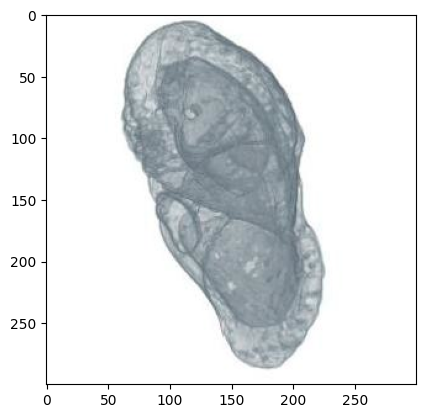

In [17]:
plt.imshow(image1)

## Helper functions

In [18]:
# Check the timm model config to make sure this normalization matches the model being used.
# The config is printed below when the model is defined.

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# The image must be of type uint8 or ToTensor() will not scale it correctly.
# assert image.dtype == 'uint8'

transform = transforms.Compose([transforms.ToTensor(),
                               normalize])


In [19]:
def display_images(df, remove_top_half=False, remove_bottom_half=False):
    
    """
    Display jpg images in a grid.
    """
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 1
    cols = 6

    for i in range(rows*cols):

        fname = df.loc[i, 'image_fname']
        label = df.loc[i, 'label']

        path = base_path + '/visualizations/visualizations/labelled/' + fname
        image = cv2.imread(path)

        if remove_top_half==True:
            # Remove the top half
            image = image[300:, :]  # Keep only the bottom 300 rows

        if remove_bottom_half==True:
            image = image[:300, :]

        # Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Shape: (300, 300)

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


In [20]:
def display_images_from_batch(data):
    
    """
    Display torch tensor images from the dataloader.
    """
    
    images = data['images']
    targets = data['targets']
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 1
    cols = 6

    for i in range(rows*cols):

        image = images[i]
        label = targets[i]

        # convert from (C, H, W) to (H, W, C) format
        image = image.permute((1, 2, 0))

        # select the first channel only
        image = image[:, :, 0]

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [21]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Display images from each class

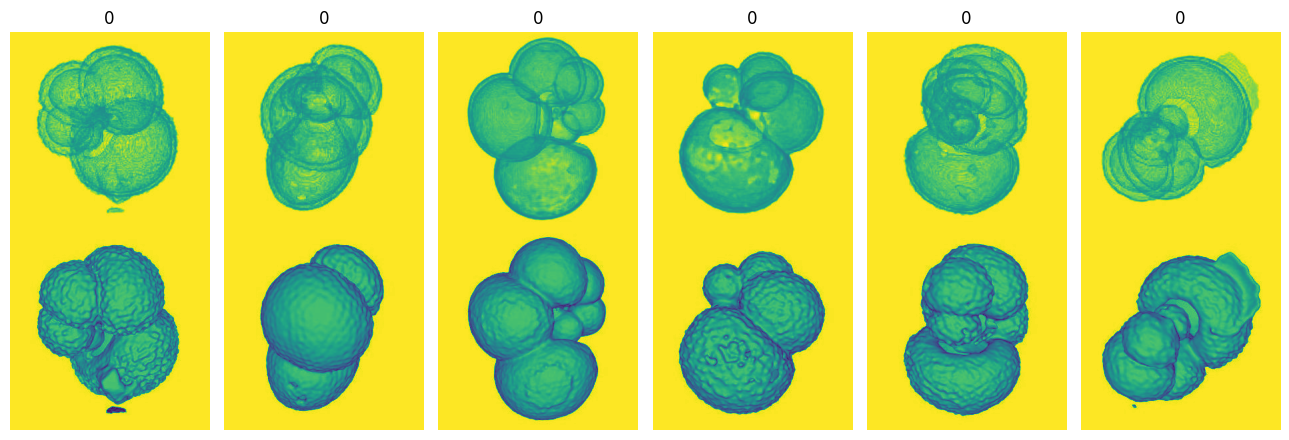

In [22]:
# Entire image

display_images(df_data, remove_top_half=False)

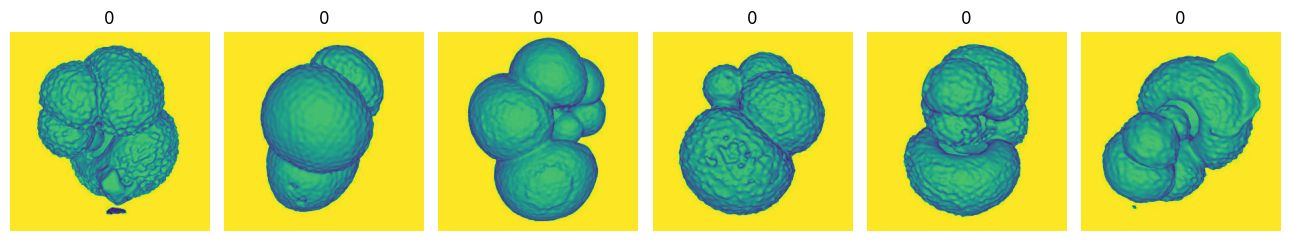

In [23]:
# Sliced image

display_images(df_data, remove_top_half=True)

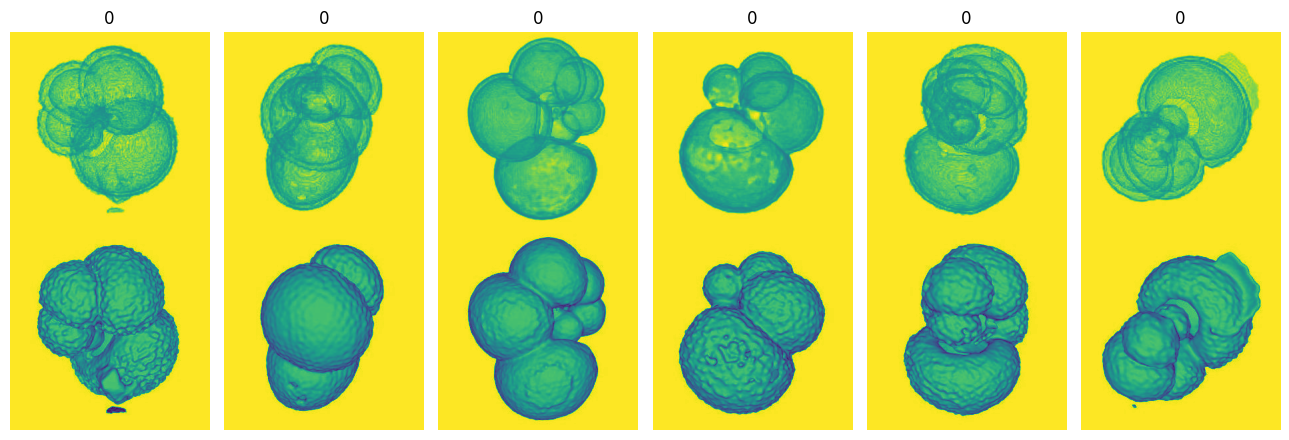

In [24]:
# Sliced image

display_images(df_data, remove_top_half=False, remove_bottom_half=False)

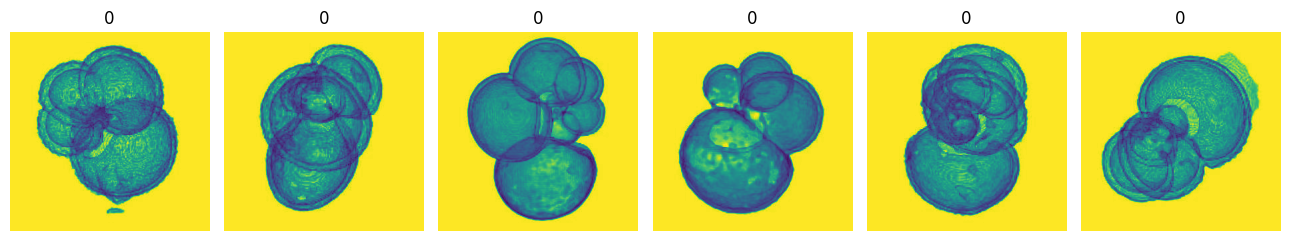

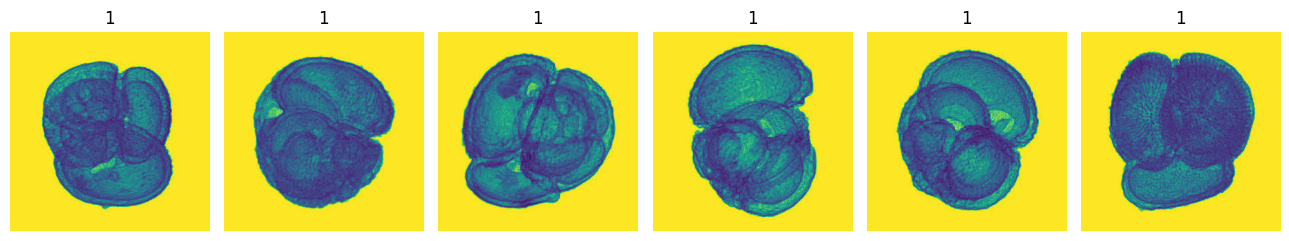

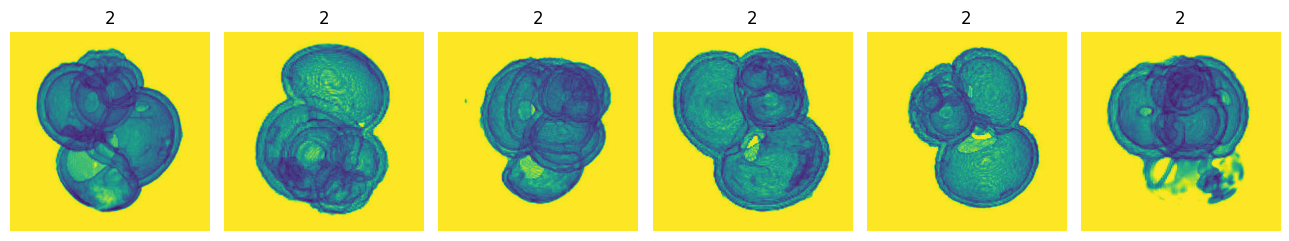

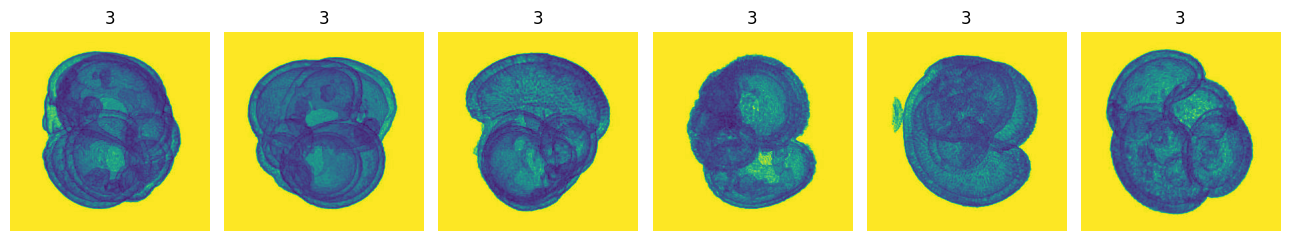

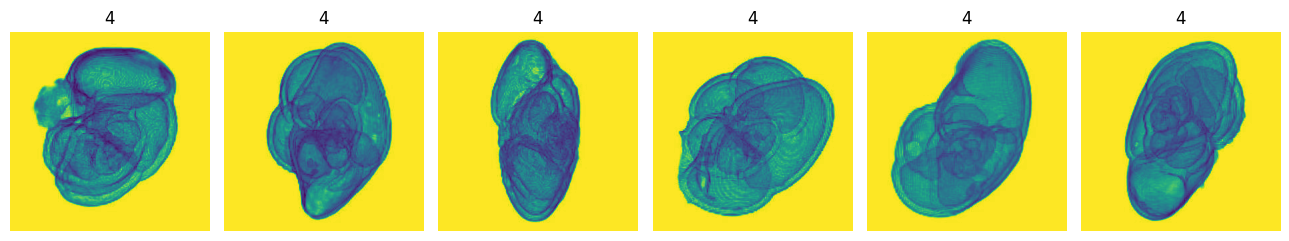

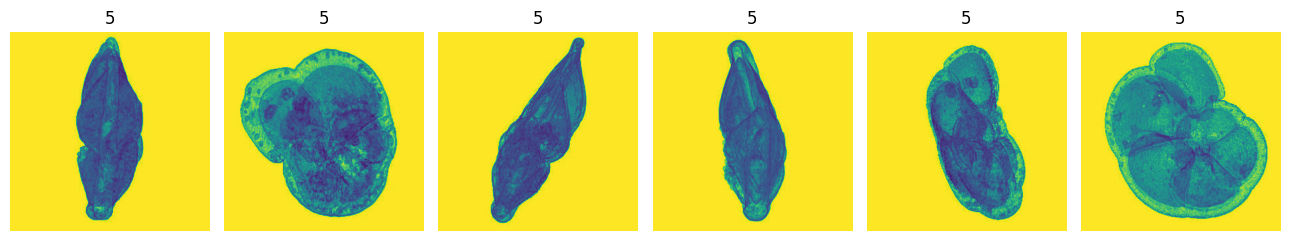

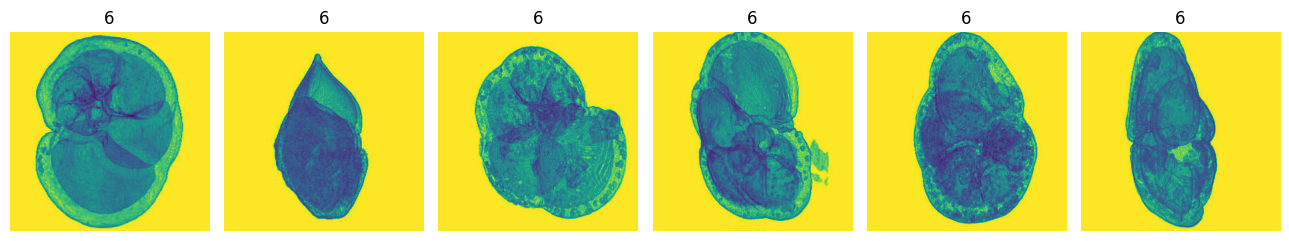

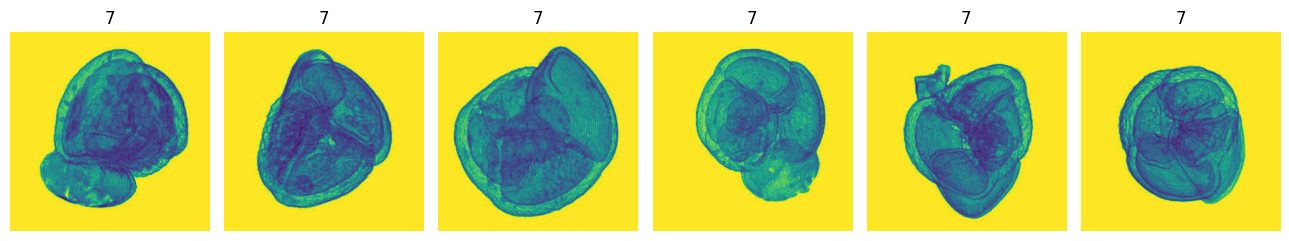

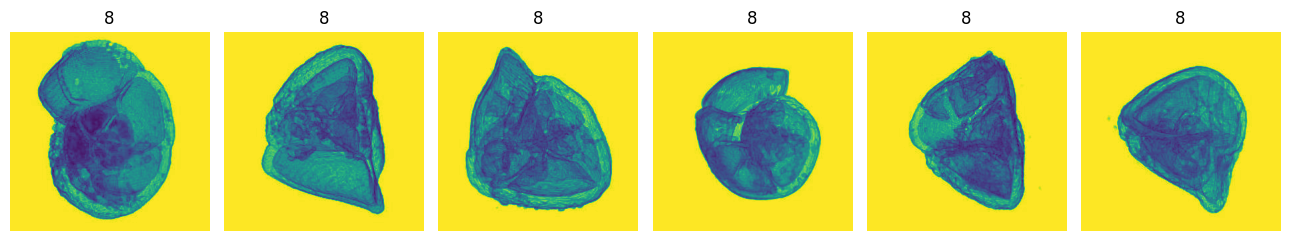

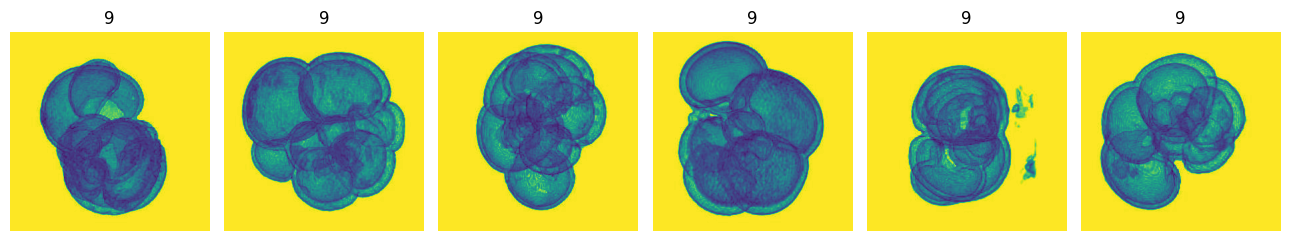

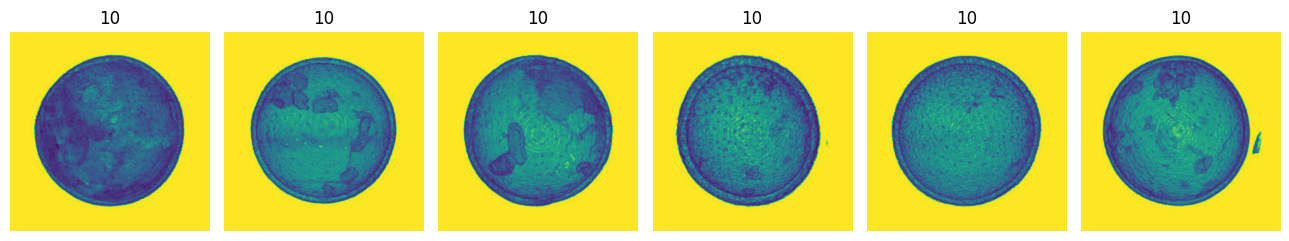

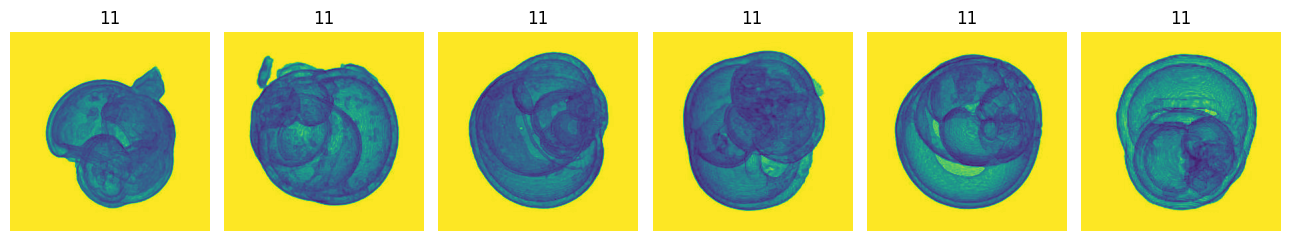

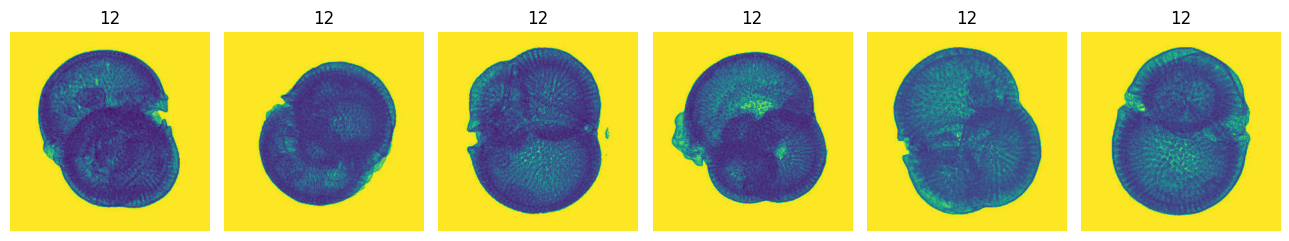

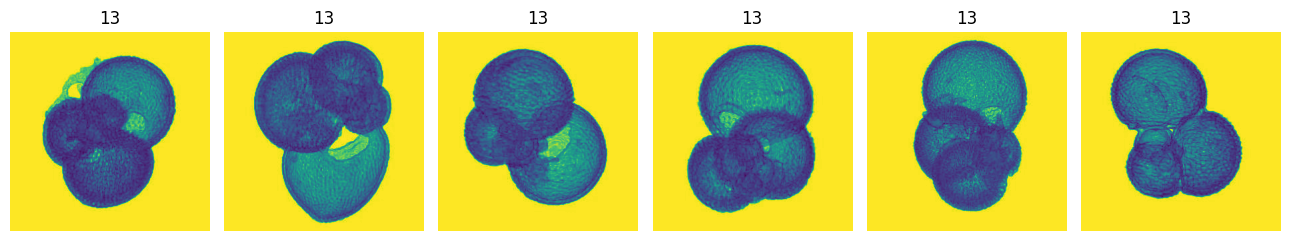

In [25]:
for i in range(0, len(CLASS_LIST)):

    df = df_data[df_data['label'] == CLASS_LIST[i]]
    df = df.reset_index(drop=True)

    display_images(df, remove_top_half=False, remove_bottom_half=True)

## Set up augmentation

Augmentation will help reduce overfitting and also help the model generalize better to unseen data.

In [26]:
import albumentations as albu

# Define the augmentations

def get_training_augmentation():
    
    train_transform = [
    albu.HorizontalFlip(always_apply=False, p=0.5),
    albu.VerticalFlip(always_apply=False, p=0.5),
    albu.ShiftScaleRotate (shift_limit=0.0625, scale_limit=0.1, rotate_limit=270, 
                           always_apply=False, p=0.6),
    #albu.Blur(blur_limit=7, always_apply=False, p=0.3),
    albu.OneOf([
        #albu.RandomContrast(),
        albu.RandomGamma(),
        #albu.RandomBrightness(), #### This is creating an error
        ], p=0.5),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.5),
   
    ]
  
    return albu.Compose(train_transform)



uint8
108
255
(300, 300)


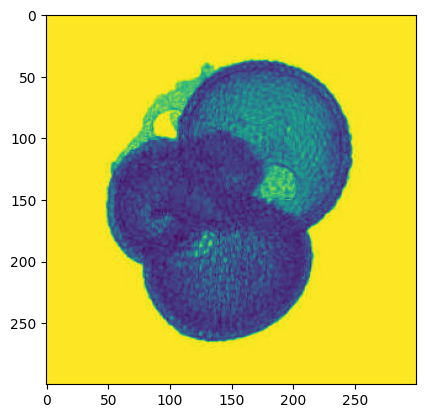

In [27]:
# Check the augmentation setup for one image.

i = 0   

# Load an image
fname = df_data.loc[i, 'image_fname']

fname = df.loc[i, 'image_fname']
path = base_path + '/visualizations/visualizations/labelled/' + fname

image = cv2.imread(path)

#image = image[300:, :]
image = image[:300, :]

# Convert to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print(image.dtype)
print(image.min())
print(image.max())
print(image.shape)

plt.imshow(image)
plt.show()

104
255
(300, 300)


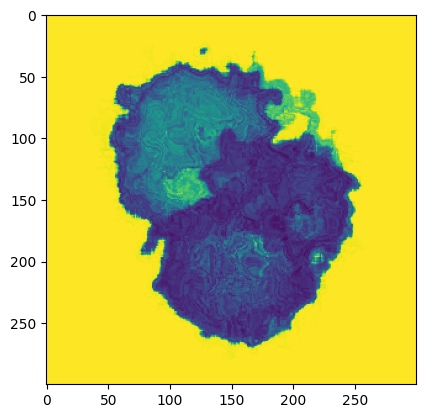

In [28]:
# Augment the image

augmentation = get_training_augmentation()

sample = augmentation(image=image)
image = sample['image']


print(image.min())
print(image.max())

print(image.shape)


plt.imshow(image)
plt.show()

## Create the folds

In [29]:
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

NUM_FOLDS = 5

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=101)

for fold, ( _, val_) in enumerate(skf.split(X=df_data, y=df_data.label)):
      df_data.loc[val_ , "fold"] = fold
        
df_data['fold'].value_counts()

fold
4.0    42
0.0    42
1.0    42
3.0    42
2.0    42
Name: count, dtype: int64

In [30]:
# Check the number of val images

df = df_data[df_data['fold'] == 0.0]

df['label'].value_counts()

label
0     3
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
11    3
12    3
13    3
Name: count, dtype: int64

## Create the dataloader

In [31]:
df_test.head()

id      image_fname  label
0   0  foram_00000.jpg      0
1   1  foram_00001.jpg      0
2   2  foram_00002.jpg      0
3   3  foram_00003.jpg      0
4   4  foram_00004.jpg      0

In [32]:
class CompDataset(Dataset):
    
    def __init__(self, df, augmentation=None, preprocessing=transform, source='train'):
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.source = source
        
    def __len__(self):
        return len(self.df)
        
        
        
    def __getitem__(self, index):
        
        # Load the image
        
        fname = self.df.loc[index, 'image_fname']
        
        if self.source == 'train':
            #path = base_path + 'images/' + fname + '.jpg'
            path = base_path + '/visualizations/visualizations/labelled/' + fname
        else:
            #path = base_path + 'image_holdouts/' + fname + '.jpg'
            path = base_path + '/visualizations/visualizations/unlabelled/' + fname
        
        image = cv2.imread(path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Remove the top half
        #image = image[300:, :]

        # Remove the bottom half
        image = image[:300, :]

        # Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Convert back to BGR (3 channels but still looks gray)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # resize the image
        # is cv2.INTER_CUBIC the same as bicubic interpolation?
        # bicubic is in the timm model config
        image = cv2.resize(image, 
                           (IMAGE_SIZE, IMAGE_SIZE), 
                           interpolation=cv2.INTER_CUBIC)
        
        
        # Target

        target = self.df.loc[index, 'label']
    
        target = torch.tensor(target, dtype=torch.long)
        

   
        # Apply augmentations
    
        if self.augmentation:
            
            sample = self.augmentation(image=image)
            image = sample['image']
            
        
        # Apply preprocessing
        
        if self.preprocessing:
            
            # The image must be of type uint8 or ToTensor() will not scale it correctly.
            assert image.dtype == 'uint8'
            
            image = self.preprocessing(image)
            
            
        return {
                "images": image,
                "targets": target
                }
    
    

## Test the dataloader

In [33]:
# Intialize the fold dataframes
fold = 0

df_train = df_data[df_data['fold'] != 0]
df_val = df_data[df_data['fold'] == 0]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(df_train.shape)
print(df_val.shape)

(168, 4)
(42, 4)


In [34]:
train_data = CompDataset(df_train, augmentation=get_training_augmentation(),
                         preprocessing=transform)

val_data = CompDataset(df_val, augmentation=None,
                      preprocessing=transform)



train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                       num_workers=NUM_CORES)



print(len(train_dataloader))
print(len(val_dataloader))

21
6


In [35]:
# Get one train batch

data = next(iter(train_dataloader))

print(data['images'].shape)
print(data['targets'])

torch.Size([8, 3, 384, 384])
tensor([13,  1,  6,  7,  6,  8,  8,  0])


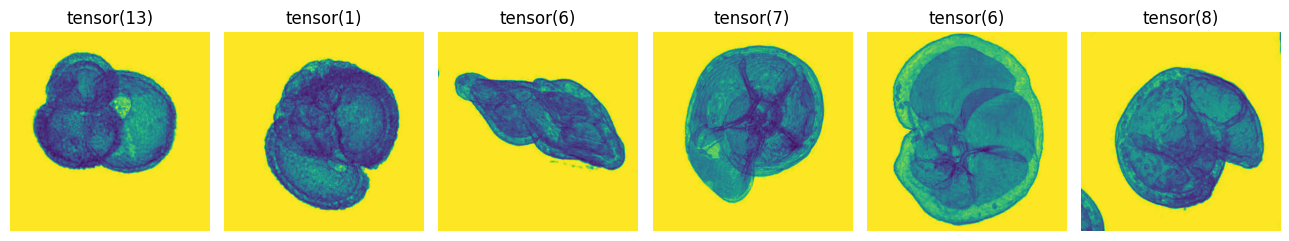

In [36]:
# Display images in the batch to 
# make sure that the dataloader output is okay.

display_images_from_batch(data)

In [37]:
# Get one val batch

data = next(iter(val_dataloader))

print(data['images'].shape)
print(data['targets'])

torch.Size([8, 3, 384, 384])
tensor([0, 0, 0, 1, 1, 1, 2, 2])


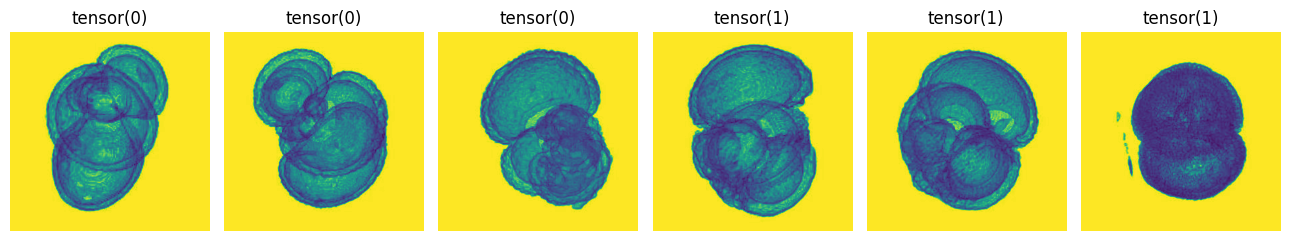

In [38]:
display_images_from_batch(data)

## Check what timm models are available

In [39]:
# This prints all available timm models

import timm
from pprint import pprint

model_names = timm.list_models(pretrained=True)

#pprint(model_names)

In [40]:
# Print only efficientnet models

timm.list_models('swin*', pretrained=True)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


In [41]:
"""

model = timm.create_model('swin_large_patch4_window12_384', 
                          pretrained=True)

#model.default_cfg

"""

"\n\nmodel = timm.create_model('swin_large_patch4_window12_384', \n                          pretrained=True)\n\n#model.default_cfg\n\n"

In [42]:
"""

pool_types = ['avg', 'max', 'avgmax', 'catavgmax', '']

model = timm.create_model('efficientnet_b1', pretrained=True, 
                          num_classes=NUM_CLASSES, global_pool='catavgmax')

"""

"\n\npool_types = ['avg', 'max', 'avgmax', 'catavgmax', '']\n\nmodel = timm.create_model('efficientnet_b1', pretrained=True, \n                          num_classes=NUM_CLASSES, global_pool='catavgmax')\n\n"

In [43]:
"""

num_in_features = model.get_classifier().in_features

# Replace the existing classifier. It's named: classifier
model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=NUM_CLASSES, bias=False))

#print(model)

"""

"\n\nnum_in_features = model.get_classifier().in_features\n\n# Replace the existing classifier. It's named: classifier\nmodel.classifier = nn.Sequential(\n    nn.BatchNorm1d(num_in_features),\n    nn.Linear(in_features=num_in_features, out_features=512, bias=False),\n    nn.ReLU(),\n    nn.BatchNorm1d(512),\n    nn.Dropout(0.4),\n    nn.Linear(in_features=512, out_features=NUM_CLASSES, bias=False))\n\n#print(model)\n\n"

## **Test the model

In [44]:
"""

# Create an input batch

data = next(iter(train_dataloader))

print(data['images'].shape)
print(data['targets'])

"""

"\n\n# Create an input batch\n\ndata = next(iter(train_dataloader))\n\nprint(data['images'].shape)\nprint(data['targets'])\n\n"

In [45]:
"""

model.to(device)

# put the model in eval mode
model.eval()

images = data['images']
targets = data['targets']

images = images.to(device, dtype=torch.float)
targets = targets.to(device, dtype=torch.long)

outputs = model(images)

print(outputs.shape)

"""

"\n\nmodel.to(device)\n\n# put the model in eval mode\nmodel.eval()\n\nimages = data['images']\ntargets = data['targets']\n\nimages = images.to(device, dtype=torch.float)\ntargets = targets.to(device, dtype=torch.long)\n\noutputs = model(images)\n\nprint(outputs.shape)\n\n"

## Calculate the loss

In [46]:
"""

def loss_fn(outputs, targets):
    
    # change shape from (8) to (8,1)
    #targets = targets.unsqueeze(dim=1)
    #loss = nn.BCELoss()
    
    # CrossEntropyLoss has a softmax included.
    loss = nn.CrossEntropyLoss()
    output = loss(outputs, targets)

    return output


loss = loss_fn(outputs, targets)

loss.item()


"""

'\n\ndef loss_fn(outputs, targets):\n    \n    # change shape from (8) to (8,1)\n    #targets = targets.unsqueeze(dim=1)\n    #loss = nn.BCELoss()\n    \n    # CrossEntropyLoss has a softmax included.\n    loss = nn.CrossEntropyLoss()\n    output = loss(outputs, targets)\n\n    return output\n\n\nloss = loss_fn(outputs, targets)\n\nloss.item()\n\n\n'

## Calculate the metric

In [47]:
"""

from sklearn.metrics import accuracy_score

def metric_fn(outputs, targets):
    
    softmax = nn.Softmax(dim=1)
    outputs = softmax(outputs)
    
    y_true = targets.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    
    y_pred = np.argmax(y_pred, axis=1)
    
    score = accuracy_score(y_true, y_pred)
    
    return score


acc = metric_fn(outputs, targets)

acc

"""

'\n\nfrom sklearn.metrics import accuracy_score\n\ndef metric_fn(outputs, targets):\n    \n    softmax = nn.Softmax(dim=1)\n    outputs = softmax(outputs)\n    \n    y_true = targets.cpu().detach().numpy()\n    y_pred = outputs.cpu().detach().numpy()\n    \n    y_pred = np.argmax(y_pred, axis=1)\n    \n    score = accuracy_score(y_true, y_pred)\n    \n    return score\n\n\nacc = metric_fn(outputs, targets)\n\nacc\n\n'

## Engine - Training and Evaluation

We will monitor loss and accuracy during training.

In [48]:
def loss_fn(outputs, targets):
    
    # change shape from (8) to (8,1)
    #targets = targets.unsqueeze(dim=1)
    #loss = nn.BCELoss()
    
    # CrossEntropyLoss has a softmax included.
    loss = nn.CrossEntropyLoss()
    output = loss(outputs, targets)

    return output

In [49]:
from sklearn.metrics import accuracy_score

def metric_fn(outputs, targets):
    
    softmax = nn.Softmax(dim=1)
    outputs = softmax(outputs)
    
    y_true = targets.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    
    y_pred = np.argmax(y_pred, axis=1)
    
    score = accuracy_score(y_true, y_pred)
    
    return score

In [50]:
def train_fn(df, model, optimizer, device):

    data = CompDataset(df, augmentation=get_training_augmentation(), 
                       preprocessing=transform)


    data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                           num_workers=NUM_CORES)
    
    model.train()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)
    
    fin_targets = []
    
    total_loss = 0
    
    loss_list = []
    score_list = []
    
    

    for i, data in tq.tqdm(enumerate(data_loader), total=len(data_loader)):
        
        images = data['images']
        targets = data['targets']


        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        

        outputs = model(images)

        loss = loss_fn(outputs, targets)
            
        loss.backward()
        optimizer.step()
        

        loss_list.append(loss.item())
        
        # Calculate the score
        score = metric_fn(outputs, targets)
        score_list.append(score)


    # Calculate the mean loss for all batches.
    mean_loss = sum(loss_list)/len(loss_list)


    # Calculate the mean score for all batches.
    mean_score = sum(score_list)/len(score_list)
        
        
    return mean_loss, mean_score

In [51]:

def eval_fn(df, model, device):
    
    data = CompDataset(df, augmentation=None, 
                       preprocessing=transform)

    data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                           num_workers=NUM_CORES)
    
    model.eval()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(False)
    
  
    fin_targets = []
    loss_list = []
    score_list = []
    

    for i, data in tq.tqdm(enumerate(data_loader), total=len(data_loader)):
        
        images = data['images']
        targets = data['targets']


        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)


        outputs = model(images)
        
        
        # Calculate the loss
        loss = loss_fn(outputs, targets)
        
        loss_list.append(loss.item())
        
        # Calculate the score
        score = metric_fn(outputs, targets)
        score_list.append(score)
        
        
        outputs = outputs.cpu().detach().numpy()
        

    
    # Calculate the mean loss for all batches.
    mean_loss = sum(loss_list)/len(loss_list)


    # Calculate the mean score for all batches.
    mean_score = sum(score_list)/len(score_list)
    

    return mean_loss, mean_score

In [52]:
# Define the inference function

def inference_fn(df, model, device, source='train'):
    
    data = CompDataset(df,
                       preprocessing=transform, source=source)

    data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                           num_workers=NUM_CORES)
    
    model.eval()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(False)

    

    for i, data in tq.tqdm(enumerate(data_loader), total=len(data_loader)):
        
        images = data['images']

        images = images.to(device, dtype=torch.float)


        outputs = model(images)
        
        
        # convert to numpy so we can stack the batches.
        outputs = outputs.cpu().detach().numpy()
        
        # stack the preds from each batch
        if i == 0:
            fin_outputs = outputs
        else:
            fin_outputs = np.vstack((fin_outputs, outputs))
        
        

    return fin_outputs

## Training

In [53]:
scores_list = []

# For each fold...
for fold_index in range(START_FOLD, STOP_FOLD):
    
    print('\n== Fold Model', fold_index)
    
    
    # Get df_train and df_val
    # ........................

    # Intialize the fold dataframes
    df_train = df_data[df_data['fold'] != fold_index]
    df_val = df_data[df_data['fold'] == fold_index]
    
    # concat the pseudo data to df_train
    #df_train = pd.concat([df_train, df_pseudo], axis=0)
    

    # Reset the indices or the dataloader won't work.
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    

    #################
    # For testing only.
    # Comment this out during training.
    
    #df_train = df_train[0:5]
    #df_val = df_val[0:5]
    ##################
    
    
    # Define the model
    # ----------------
    
    model = timm.create_model('swin_large_patch4_window12_384', pretrained=True, 
                          num_classes=NUM_CLASSES)

    
    model.to(device)


    # Define the optimizer
    # --------------------
    
    optimizer = torch.optim.Adam(model.parameters(), lr=L_RATE)
    
   

    best_score = 0
    early_stopping_count = 0

    #### CANGE MAX TO MIN when monitoring accuracy
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.05, 
                                                           patience=2, threshold=0.000001)

    for epoch in range(0, NUM_EPOCHS):  

        print('\nEpoch', epoch)
        # print the learning rate
        print('Learning_rate:', optimizer.state_dict()['param_groups'][0]['lr'])

        # Train the model.
        mean_train_loss, mean_train_score = train_fn(df_train, model, optimizer, device)

        # Use the trained model to predict on the val set.
        mean_val_loss, mean_val_score = eval_fn(df_val, model, device)

        scheduler.step(mean_val_score)



        print(f"Train loss = {mean_train_loss}")
        print(f"Val loss = {mean_val_loss}")
        print(f"Train score = {mean_train_score}")
        print(f"Val score = {mean_val_score}")



        # Save the model

        path_model = f'{fold_index}_model.bin'

        if epoch == 0:
            torch.save(model.state_dict(), path_model)
            print('Model saved:', path_model)

            early_stopping_count = 0

        if mean_val_score > best_score:
            torch.save(model.state_dict(), path_model)
            print('Val score improved. Model saved:', path_model)
            best_score = mean_val_score

            early_stopping_count = 0

        else:
            early_stopping_count = early_stopping_count + 1

        if early_stopping_count > PATIENCE:
            # Stop the loop.
            # Move to the next fold when doing cross validaton.
            print('\n *** Early stopping. ***')
            break

        print('\n')


    # At the end of fold training save the best score
    scores_list.append(best_score)
            
        
cv = sum(scores_list)/len(scores_list)

print('Fold acc: ', scores_list)
print('Acc CV: ', cv)


== Fold Model 0


model.safetensors:   0%|          | 0.00/801M [00:00<?, ?B/s]


Epoch 0
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.612137442543393
Val loss = 2.2587718963623047
Train score = 0.08333333333333333
Val score = 0.25
Model saved: 0_model.bin
Val score improved. Model saved: 0_model.bin



Epoch 1
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.01262066477821
Val loss = 1.5974110911289852
Train score = 0.30952380952380953
Val score = 0.4375
Val score improved. Model saved: 0_model.bin



Epoch 2
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.716512680053711
Val loss = 1.6026703615983326
Train score = 0.4107142857142857
Val score = 0.5416666666666666
Val score improved. Model saved: 0_model.bin



Epoch 3
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.3924931486447651
Val loss = 0.9476266764104366
Train score = 0.5476190476190477
Val score = 0.7291666666666666
Val score improved. Model saved: 0_model.bin



Epoch 4
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.9401978453000387
Val loss = 1.2515295123060544
Train score = 0.6607142857142857
Val score = 0.4791666666666667



Epoch 5
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.8635488322802952
Val loss = 0.8027190417051315
Train score = 0.6785714285714286
Val score = 0.6875



Epoch 6
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.7099146928106036
Val loss = 0.9014541115611792
Train score = 0.7440476190476191
Val score = 0.75
Val score improved. Model saved: 0_model.bin



Epoch 7
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.5336079036905652
Val loss = 1.0157827449341614
Train score = 0.8333333333333334
Val score = 0.6666666666666666



Epoch 8
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.6377224304846355
Val loss = 0.965606023867925
Train score = 0.8095238095238095
Val score = 0.7708333333333334
Val score improved. Model saved: 0_model.bin



Epoch 9
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.4992410909561884
Val loss = 0.7714009787887335
Train score = 0.8333333333333334
Val score = 0.7708333333333334



Epoch 10
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.5286059677600861
Val loss = 0.6946348187824091
Train score = 0.8214285714285714
Val score = 0.8125
Val score improved. Model saved: 0_model.bin



Epoch 11
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.34927535748907496
Val loss = 0.9357107995698849
Train score = 0.8690476190476191
Val score = 0.7291666666666666



Epoch 12
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.4988178002337615
Val loss = 1.012497529387474
Train score = 0.8452380952380952
Val score = 0.6458333333333334



Epoch 13
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.4977443392078082
Val loss = 0.7477341530223688
Train score = 0.8511904761904762
Val score = 0.7291666666666666



Epoch 14
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2923246288583392
Val loss = 0.6414098162204027
Train score = 0.9107142857142857
Val score = 0.7708333333333334



Epoch 15
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.26276313176467303
Val loss = 0.5746246973673502
Train score = 0.9345238095238095
Val score = 0.75



Epoch 16
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.16138106087843576
Val loss = 0.5676309888561567
Train score = 0.9642857142857143
Val score = 0.7291666666666666

 *** Early stopping. ***

== Fold Model 1

Epoch 0
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.6434105918520974
Val loss = 2.390646775563558
Train score = 0.09523809523809523
Val score = 0.16666666666666666
Model saved: 1_model.bin
Val score improved. Model saved: 1_model.bin



Epoch 1
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.2327442112423124
Val loss = 1.4185419132312138
Train score = 0.23809523809523808
Val score = 0.5625
Val score improved. Model saved: 1_model.bin



Epoch 2
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.7688030004501343
Val loss = 1.579830825328827
Train score = 0.3630952380952381
Val score = 0.3958333333333333



Epoch 3
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.6153172027497065
Val loss = 0.9935969263315201
Train score = 0.4226190476190476
Val score = 0.6666666666666666
Val score improved. Model saved: 1_model.bin



Epoch 4
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.122288533619472
Val loss = 0.6968274104098479
Train score = 0.6309523809523809
Val score = 0.75
Val score improved. Model saved: 1_model.bin



Epoch 5
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.9158473114172617
Val loss = 0.7576506262024244
Train score = 0.6369047619047619
Val score = 0.7708333333333334
Val score improved. Model saved: 1_model.bin



Epoch 6
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.8800763445241111
Val loss = 0.6371289938688278
Train score = 0.7083333333333334
Val score = 0.7916666666666666
Val score improved. Model saved: 1_model.bin



Epoch 7
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.8181719737393516
Val loss = 1.0814611141880353
Train score = 0.7023809523809523
Val score = 0.6875



Epoch 8
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.8139251186734154
Val loss = 0.7243441889683405
Train score = 0.7083333333333334
Val score = 0.75



Epoch 9
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.5461645200848579
Val loss = 0.928504867956993
Train score = 0.8154761904761905
Val score = 0.7291666666666666



Epoch 10
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.47708932736090254
Val loss = 0.7363527031508662
Train score = 0.8154761904761905
Val score = 0.75



Epoch 11
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.3201284765132836
Val loss = 0.5860041410584623
Train score = 0.8869047619047619
Val score = 0.8333333333333334
Val score improved. Model saved: 1_model.bin



Epoch 12
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2694022726444971
Val loss = 0.5379057359726479
Train score = 0.9107142857142857
Val score = 0.7916666666666666



Epoch 13
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.26170126845439273
Val loss = 0.5366695947789898
Train score = 0.9285714285714286
Val score = 0.8125



Epoch 14
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.22406588255294732
Val loss = 0.5457979311128535
Train score = 0.9166666666666666
Val score = 0.8541666666666666
Val score improved. Model saved: 1_model.bin



Epoch 15
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.21745576195064045
Val loss = 0.569195503271961
Train score = 0.9285714285714286
Val score = 0.8333333333333334



Epoch 16
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2747581735519426
Val loss = 0.5753085938243506
Train score = 0.8690476190476191
Val score = 0.8333333333333334



Epoch 17
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.18543685808600413
Val loss = 0.5399979729942667
Train score = 0.9404761904761905
Val score = 0.8333333333333334



Epoch 18
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.20349912203493573
Val loss = 0.5402954851839846
Train score = 0.9285714285714286
Val score = 0.8333333333333334



Epoch 19
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.16378052275450455
Val loss = 0.5397190310468432
Train score = 0.9404761904761905
Val score = 0.8125



Epoch 20
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.18726695972006946
Val loss = 0.5395326535799541
Train score = 0.9404761904761905
Val score = 0.8125

 *** Early stopping. ***

== Fold Model 2

Epoch 0
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.682207527614775
Val loss = 2.566643714904785
Train score = 0.05952380952380952
Val score = 0.14583333333333334
Model saved: 2_model.bin
Val score improved. Model saved: 2_model.bin



Epoch 1
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.5160639853704545
Val loss = 2.149902621905009
Train score = 0.13095238095238096
Val score = 0.22916666666666666
Val score improved. Model saved: 2_model.bin



Epoch 2
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.9812904312497093
Val loss = 1.3958817571401596
Train score = 0.36904761904761907
Val score = 0.5416666666666666
Val score improved. Model saved: 2_model.bin



Epoch 3
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.6023221980957758
Val loss = 1.446156067152818
Train score = 0.44642857142857145
Val score = 0.4791666666666667



Epoch 4
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.1858433995928084
Val loss = 1.2192964522788923
Train score = 0.5892857142857143
Val score = 0.5833333333333334
Val score improved. Model saved: 2_model.bin



Epoch 5
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.0086648776417686
Val loss = 0.7845803250869116
Train score = 0.6309523809523809
Val score = 0.75
Val score improved. Model saved: 2_model.bin



Epoch 6
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.9889505867447171
Val loss = 0.9202017411589622
Train score = 0.6845238095238095
Val score = 0.7708333333333334
Val score improved. Model saved: 2_model.bin



Epoch 7
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.6096430108660743
Val loss = 0.8155123190178225
Train score = 0.8214285714285714
Val score = 0.75



Epoch 8
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.7614416396688848
Val loss = 1.3287635048230488
Train score = 0.7321428571428571
Val score = 0.5625



Epoch 9
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.7186684608459473
Val loss = 0.9206331968307495
Train score = 0.75
Val score = 0.6666666666666666



Epoch 10
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.4870139573301588
Val loss = 0.7366721853613853
Train score = 0.8630952380952381
Val score = 0.6666666666666666



Epoch 11
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.36586220438281697
Val loss = 0.7018802240490913
Train score = 0.9047619047619048
Val score = 0.6666666666666666



Epoch 12
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.33367186855702174
Val loss = 0.6985813726981481
Train score = 0.8809523809523809
Val score = 0.6875

 *** Early stopping. ***

== Fold Model 3

Epoch 0
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.5537824630737305
Val loss = 1.9917391538619995
Train score = 0.15476190476190477
Val score = 0.375
Model saved: 3_model.bin
Val score improved. Model saved: 3_model.bin



Epoch 1
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.848990417662121
Val loss = 1.4539100031057994
Train score = 0.39880952380952384
Val score = 0.4583333333333333
Val score improved. Model saved: 3_model.bin



Epoch 2
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.3039756644339788
Val loss = 1.2958375910917919
Train score = 0.5416666666666666
Val score = 0.6041666666666666
Val score improved. Model saved: 3_model.bin



Epoch 3
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.0767586259614854
Val loss = 1.2543353711565335
Train score = 0.6190476190476191
Val score = 0.6041666666666666



Epoch 4
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.0019607714244299
Val loss = 1.3313826670249302
Train score = 0.6309523809523809
Val score = 0.6041666666666666



Epoch 5
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.6474167356888453
Val loss = 1.1277981506039698
Train score = 0.7678571428571429
Val score = 0.7083333333333334
Val score improved. Model saved: 3_model.bin



Epoch 6
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.6692990376835778
Val loss = 1.35553972919782
Train score = 0.7321428571428571
Val score = 0.5833333333333334



Epoch 7
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.5197292906897408
Val loss = 1.495380360012253
Train score = 0.8273809523809523
Val score = 0.6666666666666666



Epoch 8
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.5378656653421265
Val loss = 1.1553927659988403
Train score = 0.7916666666666666
Val score = 0.5416666666666666



Epoch 9
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2843232169037774
Val loss = 1.0500333905220032
Train score = 0.9226190476190477
Val score = 0.7291666666666666
Val score improved. Model saved: 3_model.bin



Epoch 10
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2107422767827908
Val loss = 1.0682965082426865
Train score = 0.9345238095238095
Val score = 0.7291666666666666



Epoch 11
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.17843653532188564
Val loss = 1.0737765499701102
Train score = 0.9523809523809523
Val score = 0.75
Val score improved. Model saved: 3_model.bin



Epoch 12
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.1365676000714302
Val loss = 1.0763836366434891
Train score = 0.9702380952380952
Val score = 0.75



Epoch 13
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.11697882130032494
Val loss = 1.0495683119321864
Train score = 0.9702380952380952
Val score = 0.75



Epoch 14
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.15449302479447352
Val loss = 1.0238693039864302
Train score = 0.9642857142857143
Val score = 0.75



Epoch 15
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.15203228357270182
Val loss = 1.0253251505394776
Train score = 0.9702380952380952
Val score = 0.75



Epoch 16
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.12173862613382794
Val loss = 1.0281871103992064
Train score = 0.9702380952380952
Val score = 0.75



Epoch 17
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.09937906008036364
Val loss = 1.0275818814213078
Train score = 0.9821428571428571
Val score = 0.75

 *** Early stopping. ***

== Fold Model 4

Epoch 0
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.6233131204332625
Val loss = 2.473177909851074
Train score = 0.10119047619047619
Val score = 0.14583333333333334
Model saved: 4_model.bin
Val score improved. Model saved: 4_model.bin



Epoch 1
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 2.2870836655298867
Val loss = 1.7964186668395996
Train score = 0.23214285714285715
Val score = 0.375
Val score improved. Model saved: 4_model.bin



Epoch 2
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.5322287877400715
Val loss = 0.9983929296334585
Train score = 0.4880952380952381
Val score = 0.6875
Val score improved. Model saved: 4_model.bin



Epoch 3
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.4437439214615595
Val loss = 1.1634705762068431
Train score = 0.47023809523809523
Val score = 0.5625



Epoch 4
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.2542658987499418
Val loss = 1.011765256524086
Train score = 0.5238095238095238
Val score = 0.6458333333333334



Epoch 5
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.9277905623118082
Val loss = 0.6820545444885889
Train score = 0.75
Val score = 0.8125
Val score improved. Model saved: 4_model.bin



Epoch 6
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 1.0303689269792466
Val loss = 0.6794887458284696
Train score = 0.625
Val score = 0.7708333333333334



Epoch 7
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.7449509847377028
Val loss = 0.684940959016482
Train score = 0.7202380952380952
Val score = 0.7708333333333334



Epoch 8
Learning_rate: 0.0001


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.6423188022204808
Val loss = 1.0192927072445552
Train score = 0.7976190476190477
Val score = 0.5625



Epoch 9
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.46476685326723827
Val loss = 0.7331561098496119
Train score = 0.8630952380952381
Val score = 0.7083333333333334



Epoch 10
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.3611240220211801
Val loss = 0.54292664428552
Train score = 0.8809523809523809
Val score = 0.7291666666666666



Epoch 11
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.29381714300030753
Val loss = 0.4911634176969528
Train score = 0.9404761904761905
Val score = 0.8333333333333334
Val score improved. Model saved: 4_model.bin



Epoch 12
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.3154949875814574
Val loss = 0.46796853591998416
Train score = 0.9107142857142857
Val score = 0.7708333333333334



Epoch 13
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.26707486010023523
Val loss = 0.4683666142324607
Train score = 0.9404761904761905
Val score = 0.8125



Epoch 14
Learning_rate: 5e-06


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2668808152278264
Val loss = 0.4626495689153671
Train score = 0.9345238095238095
Val score = 0.8125



Epoch 15
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.21992549938814981
Val loss = 0.4619988513489564
Train score = 0.9166666666666666
Val score = 0.8125



Epoch 16
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.2343955219146751
Val loss = 0.4625067686041196
Train score = 0.9226190476190477
Val score = 0.8125



Epoch 17
Learning_rate: 2.5000000000000004e-07


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss = 0.20592214805739267
Val loss = 0.4626060326894124
Train score = 0.9285714285714286
Val score = 0.8125

 *** Early stopping. ***
Fold acc:  [0.8125, 0.8541666666666666, 0.7708333333333334, 0.75, 0.8333333333333334]
Acc CV:  0.8041666666666666


In [54]:
cv = sum(scores_list)/len(scores_list)

print('Fold acc: ', scores_list)
print('Acc CV: ', cv)

Fold acc:  [0.8125, 0.8541666666666666, 0.7708333333333334, 0.75, 0.8333333333333334]
Acc CV:  0.8041666666666666


## Review model performance

We will review the performance of the first fold model.

## Load the first fold model

In [55]:
!ls

0_model.bin  2_model.bin  4_model.bin
1_model.bin  3_model.bin  __notebook__.ipynb


In [56]:
path_model = '0_model.bin'

model.load_state_dict(torch.load(path_model))
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
            (

## Evaluate on the val set

In [57]:
# Use the trained model to predict on the val set.
# Generate a dictionary of outputs.
mean_val_loss, mean_val_score = eval_fn(df_val, model, device)

print(f"val loss = {mean_val_loss}")
print(f"val score = {mean_val_score}")

  0%|          | 0/6 [00:00<?, ?it/s]

val loss = 0.05520859797252342
val score = 0.9791666666666666


## Make a prediction on the val set

In [58]:
val_outputs = inference_fn(df_val, model, device)

val_outputs.shape

  0%|          | 0/6 [00:00<?, ?it/s]

(42, 14)

In [59]:
# Apply a softmax to the preds

# convert the val preds to a torch tensor
val_preds = torch.tensor(val_outputs)

# take the softmax
softmax = nn.Softmax(dim=1)
val_preds = softmax(val_preds)

# convert to numpy
y_pred = val_preds.cpu().detach().numpy()

# take the argmax
arg_preds = np.argmax(y_pred, axis=1)

## Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix


# convert the val preds to a torch tensor
val_preds = torch.tensor(val_outputs)

# get the probabilities
softmax = nn.Softmax(dim=1)
val_preds = softmax(val_preds)

# convert from torch tensor to numpy
y_pred = val_preds.cpu().detach().numpy()

# targets
y_true = list(df_val['label'])

# get the preds as integers
y_pred_int = y_pred.argmax(axis=1)

Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3]]


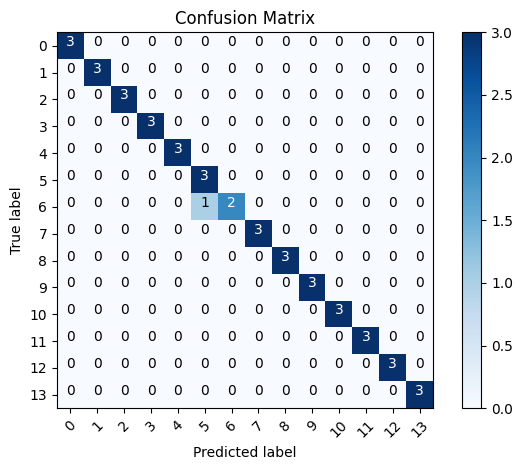

In [61]:
# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred_int)

cm_plot_labels = CLASS_LIST

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [62]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_int, target_names=CLASS_LIST_STR)
print()
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



**Precision** = Given a class prediction from a classifier, how likely is it to be correct? How much can we trust a prediction made by the model?<br>
**Recall** = Given a class, will the classifier be able to detect it? Example: Did the model in the self driving car detect all the pedestrians?<br>
**F1 Score** = The harmonic mean of the recall and precision.<br>

This is a helpful tutorial by Minsuk Heo on Accuracy, Precision and F1 Score:<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

## Make a test set prediction

Here we will make a prediction by ensembling all five fold models. Ensembled predictions tend to be more stable that single model predictions. By "more stable" I mean that there's less chance of getting a good public LB score, but then falling down the leaderboard when the private LB scores are revealed at the end of the competition.

In [63]:
# Make a prediction on each fold model and average the predictions
# Remember that CrossEntropyLoss already has a softmax included.

MODEL_LIST = ['0_model.bin', '1_model.bin', '2_model.bin', '3_model.bin', '4_model.bin']

#MODEL_LIST = ['0_model.bin']
#df_test = df_test[0:100]

for i, path_model in enumerate(MODEL_LIST):
    
    
    # Load the trained fold model
    model.load_state_dict(torch.load(path_model))
    model.to(device)
    
    test_preds = inference_fn(df_test, model, device, source='test')
    
    if i == 0:
        fin_preds = test_preds.copy()
        
    else:
        fin_preds = fin_preds + test_preds
        

# Average the preds
test_preds = fin_preds/len(MODEL_LIST)


test_preds.shape

  0%|          | 0/2277 [00:00<?, ?it/s]

  0%|          | 0/2277 [00:00<?, ?it/s]

  0%|          | 0/2277 [00:00<?, ?it/s]

  0%|          | 0/2277 [00:00<?, ?it/s]

  0%|          | 0/2277 [00:00<?, ?it/s]

(18216, 14)

## Process the predictions

In [64]:
# Get the probabilities

# convert the test preds to a torch tensor
test_preds = torch.tensor(test_preds)

# take the softmax
softmax = nn.Softmax(dim=1)
test_preds = softmax(test_preds)

# convert to numpy
test_preds = test_preds.cpu().detach().numpy()

test_preds.shape

(18216, 14)

In [65]:
# take the argmax

test_preds = np.argmax(test_preds, axis=1)

test_preds.shape

(18216,)

In [66]:
# Convert to a list

test_preds = list(test_preds)

len(test_preds)

18216

## Create a submission csv file¶

In [67]:
path = base_path + '/sample_submission.csv'

df_sub = pd.read_csv(path)

print(df_sub.shape)

df_sub.head()

(18216, 2)


id  label
0   0      9
1   1      2
2   2      3
3   3      9
4   4     11

## Add the preds to the sample submission

In [68]:
df_sub['label'] = test_preds

df_sub.head()

id  label
0   0     10
1   1      1
2   2      2
3   3      4
4   4     10

In [69]:
# Create a submission csv file

path = 'submission.csv'
df_sub.to_csv(path, index=False)

In [70]:
# Create a requirements.txt file
# This is a list of all packages and their versions that were 
# used to create this solution.

!pip freeze > requirements.txt

In [71]:
!ls

0_model.bin  2_model.bin  4_model.bin	      requirements.txt
1_model.bin  3_model.bin  __notebook__.ipynb  submission.csv
